In [2]:
import warnings
import dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from paeio import io

import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
dotenv.load_dotenv()

True

In [3]:
df = io.read_csv('https://testmlopaes.dfs.core.windows.net/testing/input/Credit/card_transdata.csv')
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


In [4]:
df.distance_from_home.quantile([0.25, 0.5, 0.75])

0.25     3.878008
0.50     9.967760
0.75    25.743985
Name: distance_from_home, dtype: float64

In [5]:
df.distance_from_last_transaction.quantile([0.25, 0.5, 0.75])

0.25    0.296671
0.50    0.998650
0.75    3.355748
Name: distance_from_last_transaction, dtype: float64

In [3]:
df.groupby('online_order')['fraud'].mean()

online_order
0.0    0.013427
1.0    0.127140
Name: fraud, dtype: float64

In [4]:
df.groupby('used_pin_number')['fraud'].mean()

used_pin_number
0.0    0.096877
1.0    0.002714
Name: fraud, dtype: float64

In [5]:
df.groupby('repeat_retailer')['fraud'].mean()

repeat_retailer
0.0    0.088449
1.0    0.087262
Name: fraud, dtype: float64

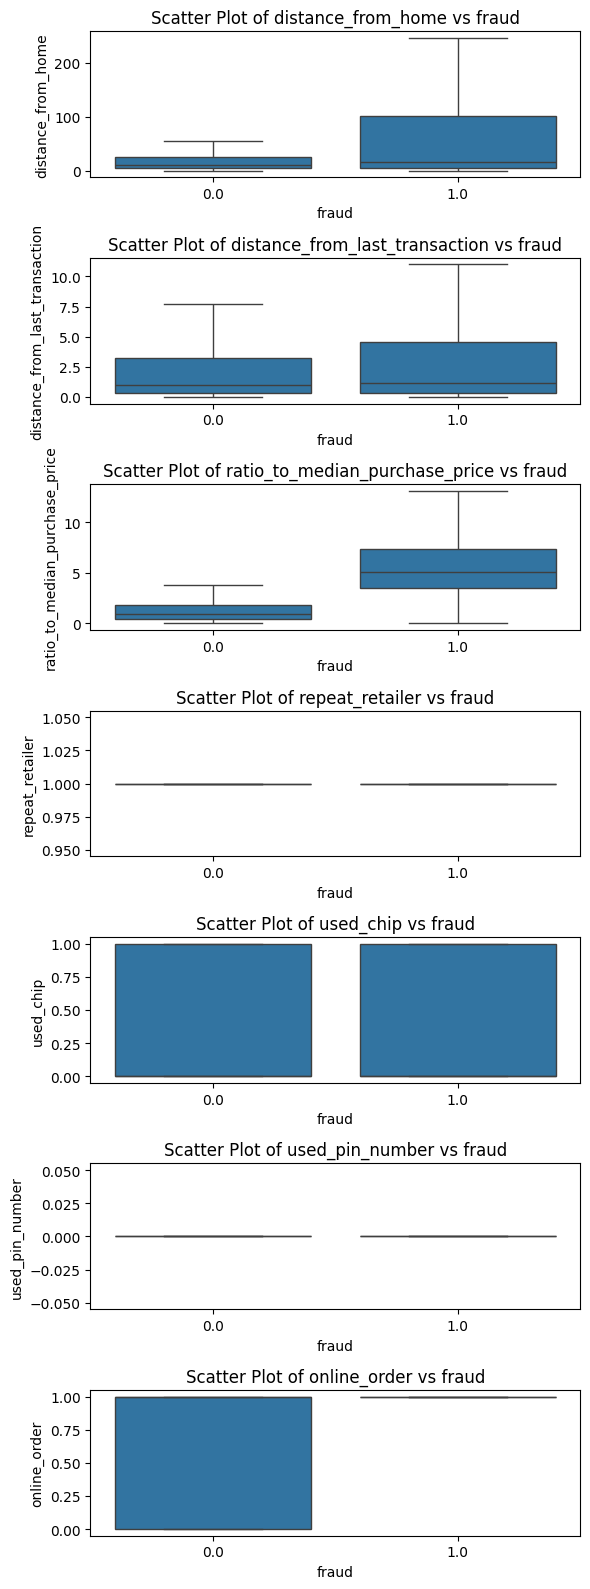

In [6]:
fig, axes = plt.subplots(nrows=len(df.columns)-1, ncols=1, figsize=(6, 16))

for i, col in enumerate(df.drop(columns=['fraud']).columns):
    sns.boxplot(x=df['fraud'], y=df[col], showfliers=False, ax=axes[i])
    axes[i].set_xlabel('fraud')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Scatter Plot of {col} vs fraud')

plt.tight_layout()
plt.show()

In [7]:
X = df.drop(columns=['fraud'])
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
model = XGBClassifier(n_estimators=10, n_jobs=-1).fit(X_train, y_train)

xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'max_leaves': [2, 4],
    'learning_rate': [0.3, 0.5]
}
grid = GridSearchCV(model, xgb_param_grid, n_jobs=-1).fit(X_train, y_train)
grid.best_params_

{'learning_rate': 0.5, 'max_depth': 3, 'max_leaves': 4, 'n_estimators': 100}

In [9]:
xgb_model = XGBClassifier(
    n_estimators=grid.best_params_['n_estimators'],
    max_depth=grid.best_params_['max_depth'],
    max_leaves=grid.best_params_['max_leaves'],
    learning_rate=grid.best_params_['learning_rate'],
    n_jobs=-1,
).fit(X_train, y_train)
pred = xgb_model.predict(X_test)
prob = xgb_model.predict_proba(X_test)

In [10]:
def evalBinaryClassifier(model, x, y, labels=['Positives','Negatives']):
    '''
    Visualize the performance of  a Logistic Regression Binary Classifier.
    
    Displays a labelled Confusion Matrix, distributions of the predicted
    probabilities for both classes, the ROC curve, and F1 score of a fitted
    Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts
    
    Parameters
    ----------
    model : fitted scikit-learn model with predict_proba & predict methods
        and classes_ attribute. Typically LogisticRegression or 
        LogisticRegressionCV
    
    x : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples
        in the data to be tested, and n_features is the number of features
    
    y : array-like, shape (n_samples,)
        Target vector relative to x.
    
    labels: list, optional
        list of text labels for the two classes, with the positive label first
        
    Displays
    ----------
    3 Subplots
    
    Returns
    ----------
    F1: float
    '''
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]
    
    #FIGURE
    plt.figure(figsize=[10,5])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Matriz de Confusão', size=15)
    plt.xlabel('Predição', size=13)
    plt.ylabel('Realidade', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Limiar(50%)')
    plt.xlim([0,1])
    plt.title('Distribuição das Predições', size=15)
    plt.xlabel('Probabilidade (predição)', size=13)
    plt.ylabel('Amostras', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.tight_layout()
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)

    print(
        f'Precision: {round(precision, 2)} | '
        f'Recall: {round(recall, 2)} | '
        f'F1 Score: {round(F1, 2)} | '
        f'AUC Score: {round(roc_auc, 2)} | ')
    return F1

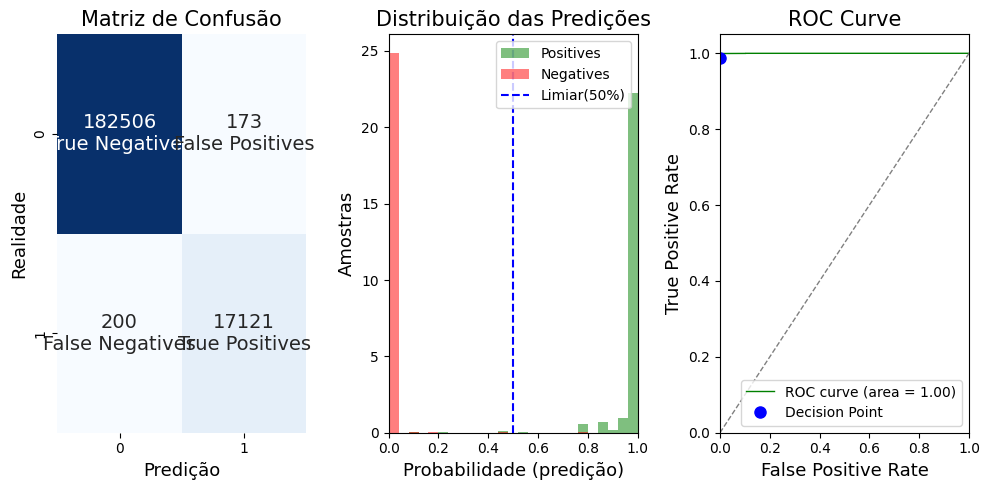

Precision: 0.99 | Recall: 0.99 | F1 Score: 0.99 | AUC Score: 1.0 | 


0.989224324714719

In [11]:
evalBinaryClassifier(xgb_model, X_test, y_test)

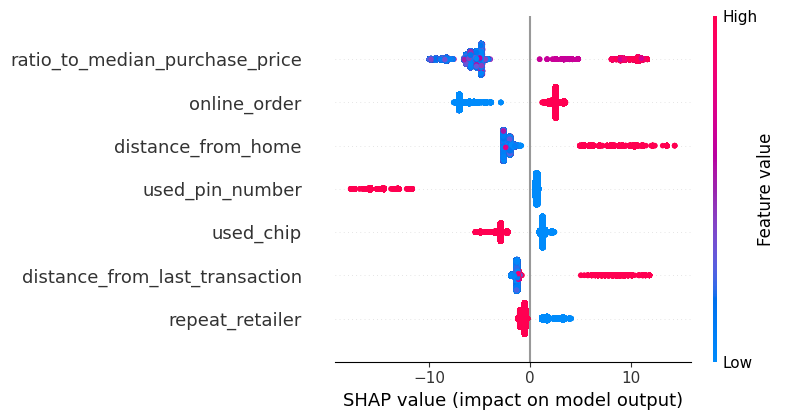

In [12]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [14]:
io.save_pickle(xgb_model, 'https://testmlopaes.dfs.core.windows.net/testing/refined/deploy/fraud_model.pkl')

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\jotap\\AppData\\Local\\Temp\\tmp5qcsak1c'

In [15]:
import pickle

In [18]:
pickle.dump(xgb_model, open('fraud_model.pkl', "wb"))

In [16]:
pickle.dump?

Signature:
pickle.dump(
    obj,
    file,
    protocol=None,
    *,
    fix_imports=True,
    buffer_callback=None,
)
Docstring:
Write a pickled representation of obj to the open file object file.

This is equivalent to ``Pickler(file, protocol).dump(obj)``, but may
be more efficient.

The optional *protocol* argument tells the pickler to use the given
protocol; supported protocols are 0, 1, 2, 3, 4 and 5.  The default
protocol is 4. It was introduced in Python 3.4, and is incompatible
with previous versions.

Specifying a negative protocol version selects the highest protocol
version supported.  The higher the protocol used, the more recent the
version of Python needed to read the pickle produced.

The *file* argument must have a write() method that accepts a single
bytes argument.  It can thus be a file object opened for binary
writing, an io.BytesIO instance, or any other custom object that meets
this interface.

If *fix_imports* is True and protocol is less than 3, pickle will try